In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# Read in words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [17]:
# build conversion of character and mapping to/from integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [107]:
# build the dataset

block_size = 3 # We take 3 character to predict the 4th
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)
#return X, Y


torch.Size([228146, 3]) torch.Size([228146])


In [255]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [40]:
C = torch.randn((27,2))

In [42]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [60]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [66]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [67]:
h

tensor([[ 0.8586, -0.0341, -0.3750,  ...,  0.7785, -0.1392,  0.3666],
        [-0.1128, -0.7669, -0.3843,  ..., -0.9124,  0.9274, -0.9330],
        [ 0.9041, -0.6560, -0.3294,  ..., -0.9914,  0.9997, -0.9864],
        ...,
        [ 0.9988,  0.9311,  0.0558,  ...,  0.9995,  0.6814, -0.8162],
        [-0.5122, -0.7579,  0.7264,  ...,  0.6956,  0.2395,  0.1202],
        [ 0.8746, -0.8019, -0.6060,  ...,  0.3622,  0.8118,  0.5451]])

In [68]:
h.shape

torch.Size([32, 100])

In [71]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [72]:
logits = h @ W2 + b2

In [73]:
counts = logits.exp()


In [74]:
probs = counts / counts.sum(1, keepdims=True)

In [76]:
probs.shape

torch.Size([32, 27])

In [79]:
loss = -probs[torch.arange(32), Y].log().mean()

tensor(14.2564)

In [80]:
# ------------ now made respectable :) ---------------

In [108]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [292]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [293]:
sum(p.nelement() for p in parameters)

11897

In [294]:
for p in parameters:
    p.requires_grad = True

In [295]:
lri = []
lossi = []
stepi = []

In [304]:
batch_size = 32
for i in range(50000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.0950076580047607


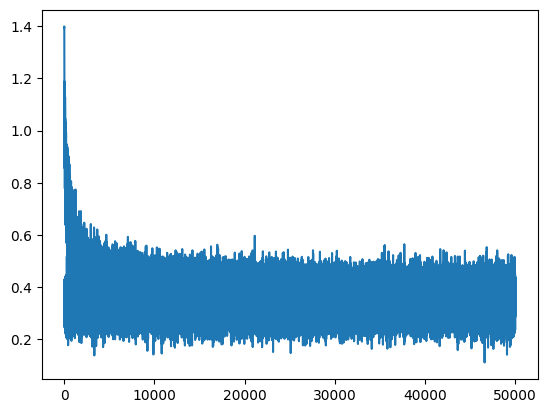

In [305]:
plt.plot(stepi, lossi)

In [306]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1751, grad_fn=<NllLossBackward0>)

In [307]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2225, grad_fn=<NllLossBackward0>)

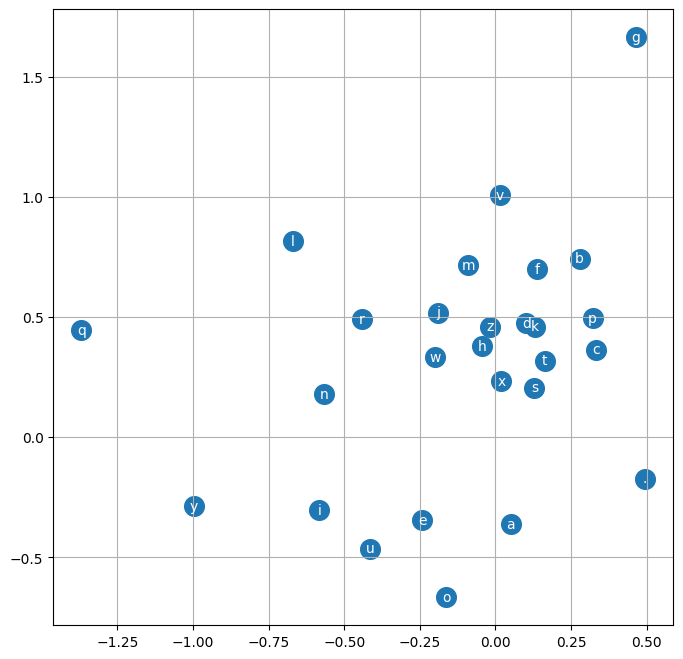

In [285]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')